In [1]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol
import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import random 
import flax 
import os 
import numpy as np 
import functools

In [2]:
class MessagePassingModel(nn.Module):
  features: int = 32
  max_degree: int = 2
  num_iterations: int = 3
  num_basis_functions: int = 8
  cutoff: float = 5.0
  max_atomic_number: int = 118  # This is overkill for most applications.


  def energy(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
    # 1. Calculate displacement vectors.
    positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
    positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
    displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

    # 2. Expand displacement vectors in basis functions.
    basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
      displacements,
      num=self.num_basis_functions,
      max_degree=self.max_degree,
      radial_fn=e3x.nn.reciprocal_bernstein,
      cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
    )

    # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
    x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, features=self.features)(atomic_numbers)

    # 4. Perform iterations (message-passing + atom-wise refinement).
    for i in range(self.num_iterations):
      # Message-pass.
      if i == self.num_iterations-1:  # Final iteration.
        # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
        # features for efficiency reasons.
        y = e3x.nn.MessagePass(max_degree=0, include_pseudotensors=False)(x, basis, dst_idx=dst_idx, src_idx=src_idx)
        # After the final message pass, we can safely throw away all non-scalar features.
        x = e3x.nn.change_max_degree_or_type(x, max_degree=0, include_pseudotensors=False)
      else:
        # In intermediate iterations, the message-pass should consider all possible coupling paths.
        y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
      y = e3x.nn.add(x, y)

      # Atom-wise refinement MLP.
      y = e3x.nn.Dense(self.features)(y)
      y = e3x.nn.silu(y)
      y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

      # Residual connection.
      x = e3x.nn.add(x, y)

    # 5. Predict atomic energies with an ordinary dense layer.
    element_bias = self.param('element_bias', lambda rng, shape: jnp.zeros(shape), (self.max_atomic_number+1))
    atomic_energies = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x)  # (..., Natoms, 1, 1, 1)
    atomic_energies = jnp.squeeze(atomic_energies, axis=(-1, -2, -3))  # Squeeze last 3 dimensions.
    atomic_energies += element_bias[atomic_numbers]

    # 6. Sum atomic energies to obtain the total energy.
    energy = jax.ops.segment_sum(atomic_energies, segment_ids=batch_segments, num_segments=batch_size)

    # To be able to efficiently compute forces, our model should return a single output (instead of one for each
    # molecule in the batch). Fortunately, since all atomic contributions only influence the energy in their own
    # batch segment, we can simply sum the energy of all molecules in the batch to obtain a single proxy output
    # to differentiate.
    return -jnp.sum(energy), energy  # Forces are the negative gradient, hence the minus sign.


  @nn.compact
  def __call__(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments=None, batch_size=None):
    if batch_segments is None:
      batch_segments = jnp.zeros_like(atomic_numbers)
      batch_size = 1

    # Since we want to also predict forces, i.e. the gradient of the energy w.r.t. positions (argument 1), we use
    # jax.value_and_grad to create a function for predicting both energy and forces for us.
    energy_and_forces = jax.value_and_grad(self.energy, argnums=1, has_aux=True)
    (_, energy), forces = energy_and_forces(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

    return energy, forces


@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return message_passing_model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )
    self.results['energy'] = energy * ase.units.kcal/ase.units.mol
    self.results['forces'] = forces * ase.units.kcal/ase.units.mol
    
    
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, forces_weight, opt_state, params):
  def loss_fn(params):
    energy, forces = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      energy_prediction=energy,
      energy_target=batch['energy'],
      forces_prediction=forces,
      forces_target=batch['forces'],
      forces_weight=forces_weight
    )
    return loss, (energy, forces)
  (loss, (energy, forces)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  energy_mae = mean_absolute_error(energy, batch['energy'])
  forces_mae = mean_absolute_error(forces, batch['forces'])
  return params, opt_state, loss, energy_mae, forces_mae


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, forces_weight, params):
  energy, forces = model_apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
  )
  loss = mean_squared_loss(
    energy_prediction=energy,
    energy_target=batch['energy'],
    forces_prediction=forces,
    forces_target=batch['forces'],
    forces_weight=forces_weight
  )
  energy_mae = mean_absolute_error(energy, batch['energy'])
  forces_mae = mean_absolute_error(forces, batch['forces'])
  return loss, energy_mae, forces_mae
    

In [3]:

os.system('pwd')
os.system('ls -ltr')
# Model hyperparameters.
features = 32
max_degree = 1
num_iterations = 3
num_basis_functions = 16
cutoff = 5.0
# Training hyperparameters.
num_train = 900
num_valid = 100

#Load the data: 
# Download the dataset.
filename = "md17_ethanol.npz"
if not os.path.exists(filename):
  print(f"Downloading {filename} (this may take a while)...")
  urllib.request.urlretrieve(f"http://www.quantum-machine.org/gdml/data/npz/{filename}", filename)
  
def prepare_datasets(key, num_train, num_valid):
  # Load the dataset.
  dataset = np.load(filename)

  # Make sure that the dataset contains enough entries.
  num_data = len(dataset['E'])
  num_draw = num_train + num_valid
  if num_draw > num_data:
    raise RuntimeError(
      f'datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}')

  # Randomly draw train and validation sets from dataset.
  choice = np.asarray(jax.random.choice(key, num_data, shape=(num_draw,), replace=False))
  train_choice = choice[:num_train]
  valid_choice = choice[num_train:]

  # Determine mean energy of the training set.
  mean_energy = np.mean(dataset['E'][train_choice])  # ~ -97000

  # Collect and return train and validation sets.
  train_data = dict(
    energy=jnp.asarray(dataset['E'][train_choice, 0] - mean_energy),
    forces=jnp.asarray(dataset['F'][train_choice]),
    atomic_numbers=jnp.asarray(dataset['z']),
    positions=jnp.asarray(dataset['R'][train_choice]),
  )
  valid_data = dict(
    energy=jnp.asarray(dataset['E'][valid_choice, 0] - mean_energy),
    forces=jnp.asarray(dataset['F'][valid_choice]),
    atomic_numbers=jnp.asarray(dataset['z']),
    positions=jnp.asarray(dataset['R'][valid_choice]),
  )
  return train_data, valid_data, mean_energy

# Create PRNGKeys.
key = jax.random.PRNGKey(0)
data_key, train_key = jax.random.split(key, 2)

# Draw training and validation sets.
train_data, valid_data, _ = prepare_datasets(data_key, num_train=num_train, num_valid=num_valid)
  

/home/marinica/Work_ML/E3x/train_ethanol
total 224292
-rw-r--r-- 1 marinica marinica 229472236 Apr  2 13:54 md17_ethanol.npz
-rw-r--r-- 1 marinica marinica     90899 Apr  3 09:57 model_params.bin
-rw-r--r-- 1 marinica marinica     40487 Apr  3 09:57 train.ipynb
-rw-r--r-- 1 marinica marinica     61752 Apr  3 09:59 run.ipynb


In [4]:

# Re-initialize the model exactly as you did before training
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
)

# Create a PRNGKey for initialization
key = random.PRNGKey(0)  # Use a key, the specific value is not crucial here

# You don't need to provide dummy data for model structure initialization
# Instead, you only need to specify the PRNGKey
# This step is assuming the model's init doesn't explicitly require the input shapes at this stage
#dummy_params = reinitialized_model.init(key)
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['atomic_numbers']))
atomic_numbers=train_data['atomic_numbers']
positions=train_data['positions'][0]
dummy_params = message_passing_model.init(key, atomic_numbers=atomic_numbers, positions=positions, dst_idx=dst_idx, src_idx=src_idx)
with open('model_params.bin', 'rb') as f:
    serialized_params = f.read()

params = flax.serialization.from_bytes(dummy_params, serialized_params)    

In [5]:

#@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return message_passing_model.apply(params,
    atomic_numbers=jax.numpy.array(atomic_numbers),
    positions= jax.numpy.array(positions),
    dst_idx=jax.numpy.array(dst_idx),
    src_idx=jax.numpy.array(src_idx),
  )

###def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
###    # Convert inputs to JAX arrays if they aren't already
###    atomic_numbers_jax = jax.numpy.array(atomic_numbers)
###    positions_jax = jax.numpy.array(positions)
###    dst_idx_jax = jax.numpy.array(dst_idx)
###    src_idx_jax = jax.numpy.array(src_idx)
###
###    # JIT-compiled inner function
###    @jax.jit
###    def compute(atomic_numbers, positions, dst_idx, src_idx):
###        return message_passing_model.apply(params,
###            atomic_numbers=atomic_numbers,
###            positions=positions,
###            dst_idx=dst_idx,
###            src_idx=src_idx,
###        )
###
###    # Call the JIT-compiled function
###    energy, forces = compute(atomic_numbers_jax, positions_jax, dst_idx_jax, src_idx_jax)
###
###    # Ensure explicit conversion from JAX arrays to NumPy arrays
###    return energy.block_until_ready().to_numpy(), forces.block_until_ready().to_numpy()
 


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )
    # Assuming energy and forces are initially JAX arrays and forces is correctly shaped as [num_atoms, 3]
    energy_np = np.array(energy.block_until_ready()).item()  # Convert to Python scalar
    forces_np = np.array(forces.block_until_ready())  # Ensure this is a 2D NumPy array, [num_atoms, 3]

    self.results['energy'] = energy_np * ase.units.kcal/ase.units.mol
    self.results['forces'] = forces_np * ase.units.kcal/ase.units.mol

# Initialize atoms object and attach calculator.
atoms = ase.Atoms(train_data['atomic_numbers'], train_data['positions'][0])
atoms.set_calculator(MessagePassingCalculator())

# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 09:59:42        0.114774        2.8041
BFGS:    1 09:59:42       -0.166414        1.6704
BFGS:    2 09:59:43       -0.317185        1.4748
BFGS:    3 09:59:43       -0.383719        0.9929
BFGS:    4 09:59:43       -0.420706        0.4258
BFGS:    5 09:59:44       -0.434858        0.3643
BFGS:    6 09:59:45       -0.461632        0.4343
BFGS:    7 09:59:45       -0.470467        0.2517
BFGS:    8 09:59:46       -0.476432        0.2130
BFGS:    9 09:59:47       -0.481058        0.2286
BFGS:   10 09:59:48       -0.485553        0.2417
BFGS:   11 09:59:48       -0.488347        0.1635
BFGS:   12 09:59:49       -0.489911        0.1215
BFGS:   13 09:59:49       -0.490953        0.1071
BFGS:   14 09:59:50       -0.491765        0.0713
BFGS:   15 09:59:50       -0.492245        0.0608
BFGS:   16 09:59:51       -0.492583        0.0705
BFGS:   17 09:59:51       -0.493062        0.0916
BFGS:   18 09:59:52       -0.493943        0.1125
B

In [ ]:
#vizu# # Write structure to xyz file.
#vizu# xyz = io.StringIO()
#vizu# ase_io.write(xyz, atoms, format='xyz')
#vizu# 
#vizu# # Visualize the structure with py3Dmol.
#vizu# view = py3Dmol.view()
#vizu# view.addModel(xyz.getvalue(), 'xyz')
#vizu# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
#vizu# view.show()

In [10]:
# Parameters.
temperature = 1000
timestep_fs = 1.0
num_steps = 2000

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # Occasionally print progress.
  if i % 40 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")


step     0 epot  0.024 ekin  0.794 etot  0.818
step    40 epot  0.015 ekin  0.791 etot  0.806
step    80 epot  0.366 ekin  0.465 etot  0.831
step   120 epot  0.185 ekin  0.624 etot  0.809
step   160 epot  0.261 ekin  0.558 etot  0.820
step   200 epot  0.360 ekin  0.462 etot  0.823
step   240 epot  0.303 ekin  0.518 etot  0.821
step   280 epot  0.303 ekin  0.509 etot  0.812
step   320 epot  0.380 ekin  0.450 etot  0.830
step   360 epot -0.013 ekin  0.805 etot  0.792
step   400 epot  0.058 ekin  0.748 etot  0.807
step   440 epot  0.034 ekin  0.775 etot  0.809
step   480 epot  0.140 ekin  0.674 etot  0.814
step   520 epot  0.149 ekin  0.679 etot  0.828
step   560 epot  0.173 ekin  0.642 etot  0.816
step   600 epot  0.230 ekin  0.590 etot  0.821
step   640 epot  0.388 ekin  0.439 etot  0.827
step   680 epot  0.061 ekin  0.747 etot  0.808
step   720 epot  0.416 ekin  0.418 etot  0.833
step   760 epot  0.089 ekin  0.712 etot  0.801
step   800 epot  0.240 ekin  0.590 etot  0.830
step   840 ep

In [ ]:
#vizu# view.getModel().setCoordinates(frames, 'array')
#vizu# view.animate({'loop': 'forward', 'interval': 0.1})
#vizu# view.show()

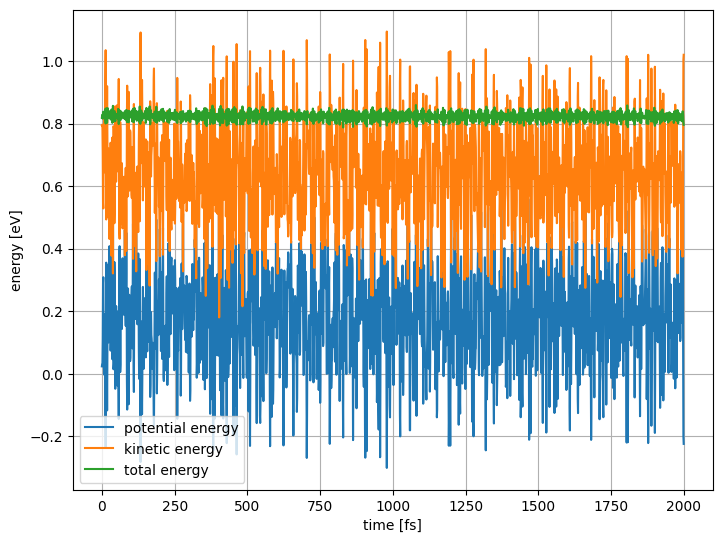

In [12]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()